# 08.3.线性回归的从零开始实现

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [3]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0,1,(num_examples,len(w)))#均值为0标准差为1，num个样本，列数为w的长度
    y = torch.matmul(X, w) + b #torch.matmul是矩阵乘法  重申一维向量认为是列向量
    y += torch.normal(0, 0.01, y.shape) #加上随机噪音
    return X, y.reshape((-1,1)) #-1表示自动计算，最终把y变成了一个列向量

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000) #生成1000个样本

`features`中的每一行都包含一个二维数据样本，`labels`中的每一行都包含一维标签值（一个标量）

In [5]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([0.1607, 0.8906]) 
label: tensor([1.4887])


'\ndetach分离出数值，不再含有梯度\n在pytorch的一些版本里面要先detach才能使用.numpy将tensor转化为numpy数组\n'

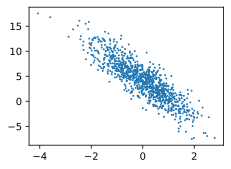

In [6]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(), labels.detach().numpy(),1);
"""
detach分离出数值，不再含有梯度
在pytorch的一些版本里面要先detach才能使用.numpy将tensor转化为numpy数组
"""

定义一个`data_iter`函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)]) #每一批的大小最大为batch_indices
        yield features[batch_indices], labels[batch_indices]
    
batch_size = 10
print(features.shape)
for X, y in data_iter(batch_size, features, labels):
    print(X,'\n',y)
    break

torch.Size([1000, 2])
tensor([[-0.2180,  0.0462],
        [ 0.1412,  0.1769],
        [ 1.6740,  0.6982],
        [ 1.0432,  1.1856],
        [-1.3033,  0.2717],
        [-0.7396, -0.5599],
        [ 0.8750,  0.2207],
        [ 0.7610,  0.1438],
        [ 0.2402,  1.6049],
        [-0.0848,  0.5679]]) 
 tensor([[ 3.5970],
        [ 3.8780],
        [ 5.1767],
        [ 2.2559],
        [ 0.6621],
        [ 4.6288],
        [ 5.1938],
        [ 5.2343],
        [-0.7698],
        [ 2.0870]])


定义初始化模型参数

In [10]:
w = torch.normal(0, 0.01, size=(2,1),requires_grad = True)
b = torch.zeros(1,requires_grad = True)

定义模型

In [12]:
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w) + b

定义损失函数

$l(\mathbf{X,y,w},b)=\frac{1}{2n} \sum_{i=1}^{n}(y_i- \langle \mathbf{x_i}, \mathbf{w} \rangle -b)^2 = \frac{1}{2n}||\mathbf{y-Xw}-b||^2$

In [14]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / (2 * batch_size)

定义优化算法

In [16]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad 
            param.grad.zero_()

训练过程

In [18]:
lr = 0.03
num_epochs = 3 #将整个数据集扫三遍
net = linreg  #返回预测的y值
loss = squared_loss
cnt = 0
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        cnt+=1
        l = loss(net(X, w, b), y) #`X`和`y`的最小批损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
    print(cnt)


epoch 1, loss 0.003704
100
epoch 2, loss 0.000013
200
epoch 3, loss 0.000005
300


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [20]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0004,  0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)


“每一次计算梯度要对整个损失函数求导，损失函数是所有样本的平均损失。这意味着每求一次梯度要把整个样本重新算一遍，计算代价大。”
求梯度要先就是对损失函数求导，示例代码中每一次求梯度时，损失函数只跟`batch_size`个样本相关，大大减小了计算量